# Runtime of Minimization Methods for Shadow Ban with PyOptSparse and Control Packages

This notebook uses the `control` and `pyoptsparse` package to solve for shadow banning policies.

In [ ]:
#!pip install control

In [1]:
import numpy as np
import control.optimal as obc
import control as ct
from pyoptsparse import SLSQP, Optimization, OPT



import matplotlib.pyplot as plt
from scripts.content_moderation import *
import networkx as nx

import winsound
import pandas as pd
import time
import seaborn as sns
import scipy.optimize 
from datetime import datetime


C:\Users\trz2\Anaconda3\lib\site-packages\pyoptsparse\pyOpt_MPI.py:68: UserWarning: mpi4py could not be imported. mpi4py is required to use the parallel gradient analysis and parallel objective analysis for non-gradient based optimizers. Continuing using a dummy MPI module from pyOptSparse.
  warnings.warn(warn)


In [2]:
###################################################
#Objective Function
def cost_mean(x, u):
    return -x.mean()/Tf - alpha*u.mean()/Tf

#Objective Function
def cost_varmax(x, u):
    return -x.var()/Tf - alpha*u.mean()/Tf

#Objective Function
def cost_varmin(x, u):
    return x.var()/Tf - alpha*u.mean()/Tf

def callback(coeffs):
    u, x  = extract_input_state(coeffs, nv, ne, npts)
    
    costs = [integral_cost(x[:, i], u[:, i]) for
                     i in range(npts)]

    # Compute the time intervals
    dt = np.diff(timepts)

    # Integrate the cost
    # TODO: vectorize
    cost = 0
    for i in range(npts-1):
        # Approximate the integral using trapezoidal rule
        cost += 0.5 * (costs[i] + costs[i+1]) * dt[i]
    obj_value = cost
    objective_values.append(obj_value)

    current_time = datetime.now()
    cnt = len(objective_values)
    print(f"Iteration {cnt}: {current_time}: Obj = {obj_value:.3f}")

# Load Network

For your network model you need the following inputs:

   1. `A` = adjacency matrix of graph G0
   2. `rates` = array of posting rate of each node
   3. `tau`, `omega` = shift function parameters
   4. `opinions0` = array of initial opinions of each node

In [227]:
omega = 1 # strength of persuasion
tau = .50 # confidence interval, easiness to pursuade

nv = 500
G0 = nx.DiGraph(nx.path_graph(nv) )
for i in range(nv):
    rate = 1
    opinion = i/(nv-1) * 1
    G0.add_node(i, opinion=opinion, rate=rate)
                
rates = np.array([G0.nodes[v]["rate"] for v in G0.nodes()])
opinions0 = np.array([G0.nodes[v]["opinion"] for v in G0.nodes()])


#adjacency matrix of network
A = nx.adjacency_matrix(G0)
A = A.tocoo()
ne = G0.number_of_edges()
#names of edges for shadowbanning in format uij
input_names = []
for e in G0.edges():
    input_names.append(f"u{e[0]}{e[1]}")
#names of nodes opinions in format thetai
output_names = []
for v in G0.nodes():
    output_names.append(f"theta{v}")
    
assert nv == A.shape[0]  #number of nodes in network should equal shape of A
#parameters of network model
params = {'A':A,'rates':rates,'tau':tau,'omega':omega}





# Create Nonlinear IO System Object

In [228]:
alpha = 0.1

#inital conditions 
x0 = opinions0
#initial guess of control
Tf = 100
npts, npts_eval = 3, 100


sys = ct.NonlinearIOSystem(
    sys_update, sys_output, states=nv,
    inputs=input_names, outputs = output_names,
    name='path network', params=params)


#bounds on control strength
constraints = [ obc.input_range_constraint(sys, np.zeros(ne), np.ones(ne)), 
               obc.state_range_constraint(sys, np.zeros(nv), np.ones(nv)) ]

#dumb initial condition
u0 = np.ones(ne)
U0 =  np.vstack([u0] * npts).T
data = shift(opinions0[A.row]- opinions0[A.col],tau,omega)

#smart initial condition (for maximizing mean)
u0_smart = (data>0).astype(int)
# Linear interpolation between u0_smart and ones
grid = np.linspace(0, 1, npts)
U0_mean= np.outer(u0_smart, 1 - grid) + np.outer(np.ones_like(u0_smart), grid)

#smart initial condition (for maximizing var)
u0_smart = (np.sign(x0[A.col]-x0.mean())*np.sign(data)>0).astype(int)
U0_varmax = np.outer(u0_smart, 1 - grid) + np.outer(np.ones_like(u0_smart), grid)


timepts = np.linspace(0, Tf, npts, endpoint=True)
t_eval = np.linspace(0, Tf, npts_eval)



##################################
integral_cost = cost_mean
U0_smart = U0_mean

ocp = obc.OptimalControlProblem(
        sys, timepts, integral_cost, trajectory_constraints=constraints,
        terminal_cost=None, terminal_constraints=[],
        initial_guess=U0_smart)
ocp.x = x0



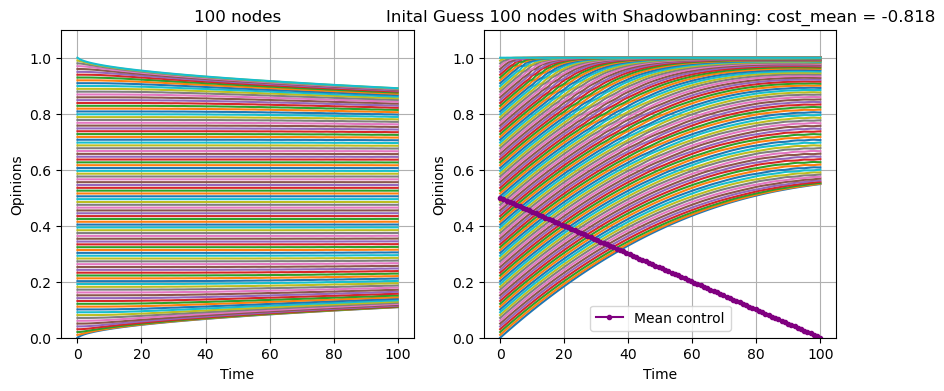

Wall time: 4.59 s


In [229]:
%%time

resp = ct.input_output_response(
                        sys, timepts, U0, x0,
                        t_eval= t_eval, params = params)

T, Opinions_no_agent, U = resp.time, resp.outputs, resp.inputs
Opinions_no_agent = Opinions_no_agent.T



plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
plt.plot(T, Opinions_no_agent)
plt.grid()
plt.xlabel("Time")
plt.ylabel("Opinions")
plt.ylim([0,1.1])
plt.title(f"{nv} nodes")


resp = ct.input_output_response(
                        sys, timepts, U0_smart, x0,
                        t_eval= t_eval, params = params)

T, Opinions, U = resp.time, resp.outputs, resp.inputs
Opinions = Opinions.T

rows = [Opinions[0,:], Opinions[49,:],Opinions[-1,:]]
ocp.initial_guess[npts*ne:] = np.concatenate(np.transpose(rows))
obj0 = ocp._cost_function(ocp.initial_guess)

plt.subplot(1,2,2)
plt.plot(T, Opinions)
plt.plot(T, 1-U.mean(axis=0), '.-', color = 'purple', label='Mean control')

plt.grid()
plt.xlabel("Time")
plt.ylabel("Opinions")
plt.ylim([0,1.1])
plt.title(f"Inital Guess {nv} nodes with Shadowbanning: {integral_cost.__name__} = {obj0:.3f}")
plt.legend()
plt.show()


In [231]:
%%time
maxiter = 100
options = {'maxiter': maxiter,'disp': True}

#initialize the opinions at the values from simulator
rows = [Opinions[0,:], Opinions[49,:],Opinions[-1,:]]
ocp.initial_guess[npts*ne:] = np.concatenate(np.transpose(rows))

objective_values = []
res = scipy.optimize.minimize(
            ocp._cost_function, ocp.initial_guess, 
            constraints=ocp.constraints, method = 'SLSQP', options=options, callback = None)



Iteration limit reached    (Exit mode 9)
            Current function value: -0.8545768151410325
            Iterations: 100
            Function evaluations: 89500
            Gradient evaluations: 100
Wall time: 34min 32s


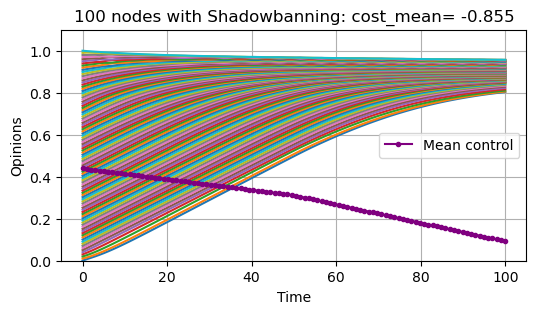

In [232]:
Ucollocation,_ = extract_input_state(res.x, nv, ne, npts)
resp = ct.input_output_response(
                        sys, timepts, Ucollocation, x0,
                        t_eval= t_eval, params = params)

plt.figure(figsize = (6,3))
T, Opinions, Ustar = resp.time, resp.outputs, resp.inputs
Opinions = Opinions.T

plt.plot(T, Opinions)
plt.plot(T, 1-Ustar.mean(axis=0), '.-', color = 'purple', label='Mean control')

plt.grid()
plt.xlabel("Time")
plt.ylabel("Opinions")
plt.ylim([0,1.1])
plt.title(f"{nv} nodes with Shadowbanning: {integral_cost.__name__}= {res.fun:.3f}")
plt.legend()
plt.show()

# Use PyOptSparse

`pyoptsparse` tries to minimize your objective.  

In [233]:
def objfunc(xdict):
    x = xdict["x"]
    u = xdict["u"]
    coeffs = np.concatenate((u, x))
    funcs = {}
    funcs["cost"] = 1*ocp._cost_function(coeffs)
    funcs["cons_collocation"] = ocp._collocation_constraint(coeffs)

    return funcs, False

In [244]:
problem = Optimization(f"{nv} node path network", objfunc)   
problem.addVarGroup("u", npts*ne, "c", lower = 0, upper = 1, value = ocp.initial_guess[:npts*ne] )
problem.addVarGroup("x", npts*nv, "c", lower = 0, upper = 1, value =  ocp.initial_guess[npts*ne:])

problem.addConGroup("cons_collocation", npts*nv, lower = 0, upper = 0)

#objective
problem.addObj('cost')

#Optimizer
optimizer_name = "ipopt"
optimizer = OPT(optimizer_name)
#optimizer.setOption("tol", 1e-6)
#optimizer.setOption("max_iter", 100)
#optimizer.setOption("print_level", 6)
#optimizer.setOption("derivative_test", "first-order")

In [ ]:
%%time
print(optimizer_name)
sol = optimizer(problem, sens= "fd")


ipopt


In [ ]:
Ucollocation = sol.xStar['u'].reshape(ne,npts)
resp = ct.input_output_response(
                        sys, timepts, Ucollocation, x0,
                        t_eval= t_eval, params = params)

plt.figure(figsize = (6,3))
T, Opinions, Ustar = resp.time, resp.outputs, resp.inputs
Opinions = Opinions.T

plt.plot(T, Opinions)
plt.plot(T, 1-Ustar.mean(axis=0), '.-', color = 'purple', label='Mean control')
plt.grid()
plt.xlabel("Time")
plt.ylabel("Opinions")
plt.ylim([0,1.1])
plt.title(f"{nv} nodes with Optimal Shadowbanning: {integral_cost.__name__} = {sol.fStar[0]:.3f}")
plt.legend()
plt.show()